# Predicting house prices using Linear Regression
##### Data Sourced from: https://www.kaggle.com/datasets/neurocipher/house-price-for-linear-regression
##### Note: This notebook was modified from the example notebook provided in the Data Analytics Module.

# ETL Pipeline.
This notebook and model used Microsoft Fabric for the ETL pipeline of the data from Excel, into a data lakehouse.

## Extract
The data was first downloaded as a CSV file from Kaggle.\
Then using a "Dataflow Gen2" in Microsoft Fabric this csv file was brought into Fabric.

## Transform
In the same Dataflow. The data was transformed for use in the model. The code for the transformation is:
```
 let
  Source = Csv.Document(Web.Contents(<file URL Redacted for Organisational Data Privacy>), [Delimiter = ",", Columns = 13, QuoteStyle = QuoteStyle.None]),
  #"Promoted headers" = Table.PromoteHeaders(Source, [PromoteAllScalars = true]),
  #"Changed column type" = Table.TransformColumnTypes(#"Promoted headers", {{"price", Int64.Type}, {"area", Int64.Type}, {"bedrooms", Int64.Type}, {"bathrooms", Int64.Type}, {"stories", Int64.Type}, {"mainroad", type text}, {"guestroom", type text}, {"basement", type text}, {"hotwaterheating", type text}, {"airconditioning", type text}, {"parking", Int64.Type}, {"prefarea", type text}, {"furnishingstatus", type text}}),
  #"Replaced value" = Table.ReplaceValue(#"Changed column type", "yes", "1", Replacer.ReplaceText, {"mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"}),
  #"Replaced value 1" = Table.ReplaceValue(#"Replaced value", "no", "0", Replacer.ReplaceText, {"mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"}),
  #"Removed columns" = Table.RemoveColumns(#"Replaced value 1", {"furnishingstatus", "prefarea"}),
  #"Changed column type 1" = Table.TransformColumnTypes(#"Removed columns", {{"price", Int64.Type}, {"area", Int64.Type}, {"bedrooms", Int64.Type}, {"bathrooms", Int64.Type}, {"stories", Int64.Type}, {"mainroad", Int64.Type}, {"guestroom", Int64.Type}, {"basement", Int64.Type}, {"hotwaterheating", Int64.Type}, {"airconditioning", Int64.Type}, {"parking", Int64.Type}})
in
  #"Changed column type 1"
```
The Dataflow Gen2 is very similar to Power Query in Excel and Power Bi.

## Load
The data was then stored in a data lakehouse before being brought into the notebook.


# Pip Installs

Installing the python libraries used in the notebook for various functions such as Exploratory data analysis, and creating and testing the Linear Regression model.

In [ ]:
!pip install numpy==1.26.4 scipy==1.11.4

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 4, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 130.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 84.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.1 requires fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2024.6.1 which is incompatible.
nni 3.0 requires filelock<3.12, but you have filelock 3.13.1 which is incompatible.


In [ ]:
!pip install sweetviz seaborn yellowbrick statsmodels google-api-python-client --quiet

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 9, Finished, Available, Finished)

# Imports
Importing the previously installed libraries, as well as some libraries that are already built into python. These libraries will be used for EDA, Visualising the data and creating the Linear Regression Model.

In [ ]:
import numpy as np
import scipy
import sweetviz as sv

import seaborn as sns
import yellowbrick
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 83, Finished, Available, Finished)

# Load the data
Microsoft Fabric imports Datasets using PySpark, this notebook uses Pandas DataFrames. This Section Imports the dataset and converts it to a pandas data from called df.

In [ ]:
# load our file as a dataframe
FabricSparkDF = spark.sql("SELECT * FROM HousePrices.dbo.Housing")

df = FabricSparkDF.select("*").toPandas()

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 58, Finished, Available, Finished)

# Initial Exploratory Data Analysis

Df.head shows the first 5 rows of data, this is useful for visually checking that the data has been imported properly with the correct columns.

In [ ]:
df.head()

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 59, Finished, Available, Finished)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking
0,10150000,16200,5,3,2,1,0,0,0,0,0
1,8400000,7950,5,2,2,1,0,1,1,0,2
2,8120000,6840,5,1,2,1,1,1,0,1,1
3,6440000,8580,5,3,2,1,0,0,0,0,2
4,6083000,4300,6,2,2,1,0,0,0,0,0


Inspecting the data using SweetViz lets me review the data and identify any extreme or missing values.

In [ ]:
#report = sv.analyze(df)
#report.show_notebook()

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 84, Finished, Available, Finished)

# Ready the data for Machine Learning - split into Train and Test sets
Splitting the data into a training and a testing set so that the model performance can be checked using the unseen test dataset.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234)

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 61, Finished, Available, Finished)

These print statements show the size of the full data as well as the two split data sets, this allows me to ensure that all the data is in either the testing or training data set.

In [ ]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)


StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 62, Finished, Available, Finished)

(545, 11)
(436, 11)
(109, 11)


# EDA on the training data set

As before, .head() lets me visually check that the data looks correct and has the correct columns.

In [ ]:
df_train.head()

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 63, Finished, Available, Finished)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking
270,5880000,6500,3,2,3,1,0,0,0,1,0
6,5565000,5400,5,1,2,1,1,1,0,1,0
358,2800000,2650,3,1,2,1,0,1,0,0,1
404,4900000,4646,3,1,2,1,1,1,0,0,2
111,4690000,5400,2,1,2,1,0,0,0,0,0


.corr() allows me to analyse the correlation between different variables.

In [ ]:
df.corr(numeric_only = True)

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 64, Finished, Available, Finished)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.296898,0.255517,0.187057,0.093073,0.452954,0.384394
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547
mainroad,0.296898,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433
guestroom,0.255517,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466
basement,0.187057,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497
hotwaterheating,0.093073,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864
airconditioning,0.452954,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173


This heatmap shows the same data as above, however showing it visually makes it easy to spot outliers within the dataset.

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 65, Finished, Available, Finished)

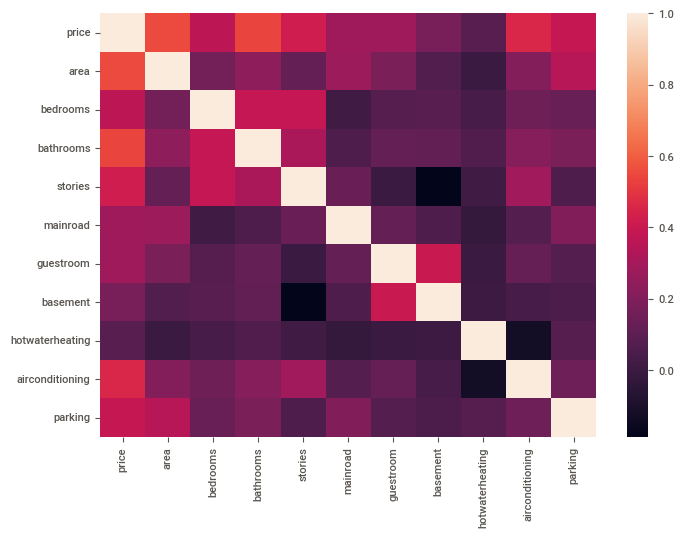

In [ ]:
sns.heatmap(df_train.corr());

# Predictive Analytics

This removes the price from the x axis of the training and testing data. It then sets the y axis to be the Price. This is how the target variable is selected, and used so that the model can be trained and tested.

In [ ]:

X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

y_train = df_train['price']
y_test = df_test['price']

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 67, Finished, Available, Finished)

This is used to check the shape of the new x and y data sets and ensure that each has the correct number of rows and columns.

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 80, Finished, Available, Finished)

(436, 10)
(109, 10)
(436,)
(109,)


To gain an understanding of the data, the below graph shows the distribution of price across the houses. It shows that the most common price is around 400,000.

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 69, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Price distribution')]

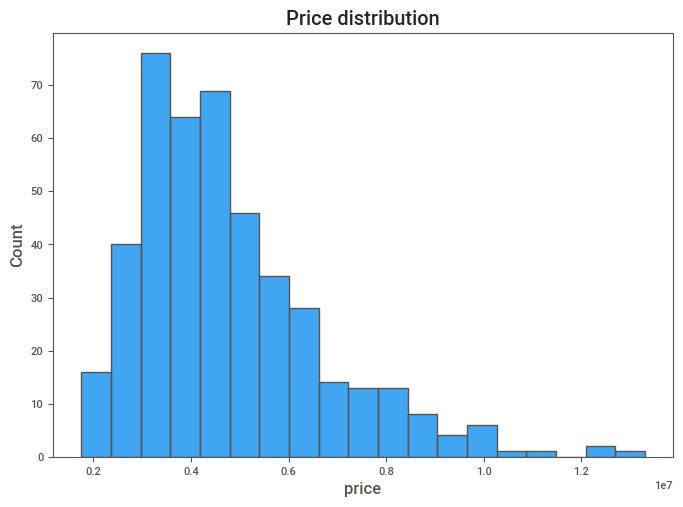

In [ ]:
sns.histplot(data=df_train, x='price').set(title='Price distribution')

## Training the model

This is the code that actually creates the Linear Regression Model.

In [ ]:

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)

print(model.score(X_test, y_test))

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 70, Finished, Available, Finished)

0.613333620457521


## Get the intercept and Coefficients

This code shows the Coefficients for each of the input variables. This reveales how the model is actually calculating the house price based on the inputs.

In [ ]:
print(model.intercept_)
pd.DataFrame(zip(X_train.columns, model.coef_), columns=["Variable", "Coeff"])

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 71, Finished, Available, Finished)

-464762.0596628571


,Variable,Coeff
0,area,277.912731
1,bedrooms,164072.401047
2,bathrooms,996615.342659
3,stories,445669.111886
4,mainroad,497197.989427
5,guestroom,473668.838176
6,basement,381613.432027
7,hotwaterheating,761794.839019
8,airconditioning,963674.494150
9,parking,310774.846439


## Explore results

This runs the model against the test data set and creates the varialbe y_pred. y_pred is used to compare the predicted results to the actual results and measure the models performance.

In [ ]:
y_pred = model.predict(X_test)
y_pred[:10]

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 72, Finished, Available, Finished)

array([4707157.11995053, 7095783.54990778, 2597591.70899975,
       2928411.74894091, 3123093.80214138, 6668072.17489522,
       5739269.19296849, 5797696.64492459, 2803351.01976993,
       2139405.39144786])

This scatter plot compares the predicted house prices to the actual house prices. This model isn't completly accuracte however this scatter plot does show a general patern.

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 73, Finished, Available, Finished)

[Text(0.5, 1.0, 'Actual v Predicted Grades')]

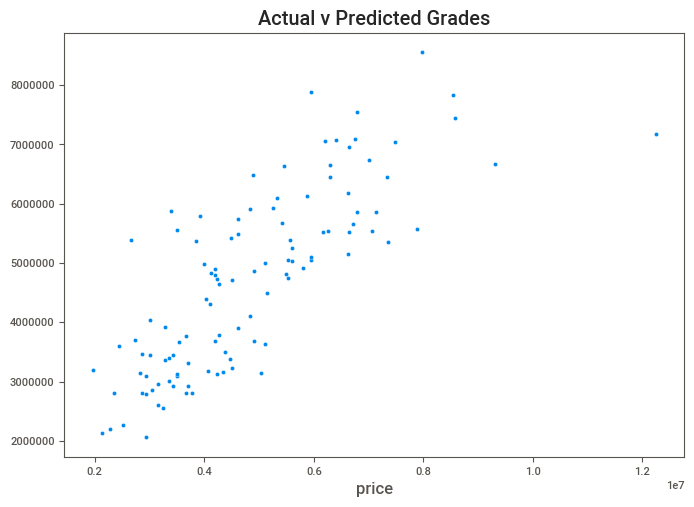

In [ ]:
# Data scatter of predicted values

sns.scatterplot(x = y_test, y =y_pred).set(title='Actual v Predicted Grades')


### Function to create Mean absolute percentage error (MAPE). This is a more interpretable measure of error

This function calculates the Mean Absolute Percentage Error. This is a useful

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    try:
      difference = y_true - y_pred
      actual = y_true
      absolute_pct_error = np.mean(np.abs(difference / actual)) * 100
    except Exception:
      absolute_pct_error = 0
    return np.round(absolute_pct_error, decimals=2)

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 74, Finished, Available, Finished)

This code creates 3 metrics to evaluate the model performance.

In [ ]:

from sklearn.linear_model import LinearRegression
import sklearn.metrics as met

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2_score = met.r2_score(y_test, y_pred)
rmse = float(format(np.sqrt(met.mean_squared_error(y_test,y_pred)),'.3f'))
mape = mean_absolute_percentage_error(y_test, y_pred)


print(r2_score)
print(rmse)
print(mape)

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 75, Finished, Available, Finished)

0.613333620457521
1087056.308
17.71


This code reformats the metrics to display them in an easy to read table.

In [ ]:
results = pd.DataFrame({
        'Model_Name': ['Linear_Regression_Basic'],
        'R2 Score': [r2_score],
        'rmse': [rmse],
        'MAPE': [mape]
})

results

StatementMeta(, eb284078-1c18-47a8-bb2d-2f293359c5ca, 76, Finished, Available, Finished)

,Model_Name,R2 Score,rmse,MAPE
0,Linear_Regression_Basic,0.613334,1087056.308,17.71


# Conclusion
This model does show that it can predict house prices based on the variables provided. However while the house prices do correlate between the predicted and actual values. It's clear from the scatter plot and the metrics that the model is not highly accurate. The Mean Absolute Percentage Error shows that the model predicts on average 17.7% from the actual value. While it is difficult to predict house prices, an Mean Absolute Percentage Error of 17.7% shows that the model needs improvement. This may be caused by a limitation in the data set itself. With only around 500 rows in total, the model can be heavily skewed by outliers. For future versions of this model, two improvements that can be made are, removing extreme values from the dataset to prevent the data being heavily skewed towards them, and using a different dataset which contains more data and as much would give the model more information to train itself on.